In [1]:
# !pip install pandas
# !pip install watermark
# !pip install seaborn
# !pip install biopython|
# !pip install sklearn
import os
import re 
# from Bio import SeqIO
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np 
import watermark
import random 
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from multiprocessing import Pool
from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = 'all'

In [2]:
left=3
right=9
signal_num=left+right

In [3]:
# 全局变量设定
signal_num = left+right
bases="ACGT"
lower_bases="acgt"
pattern = re.compile("[^acgt]")

In [4]:
output_name = "BN2Double"
train_features_df = pd.read_csv(f'{output_name}/Train_features.csv')
test_file_df = pd.read_csv(f"{output_name}/Test_predict.csv")
test_features_df = pd.read_csv(f"{output_name}/Test_features.csv")

In [5]:
test_features_df

,-3,-2,-1,0,1,2,3,4,5,6,7,8
0,2,2,2,2,3,2,0,2,1,1,1,0
1,2,3,2,2,3,0,0,2,0,2,0,1
2,3,0,2,2,3,2,0,2,3,2,3,2
3,2,1,2,2,3,0,2,2,3,0,1,3
4,1,0,2,2,3,0,0,3,3,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...
151200,3,0,0,2,3,3,0,0,0,3,1,0
151201,0,3,0,2,3,2,2,1,1,3,0,1
151202,3,2,0,2,3,3,3,1,3,2,3,3
151203,3,1,3,2,3,3,0,3,2,3,2,2


In [6]:
test_fl_df = test_features_df.copy()

In [7]:
test_fl_df["Label"] = test_file_df["label"]

In [8]:
test_fl_df

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label
0,2,2,2,2,3,2,0,2,1,1,1,0,1
1,2,3,2,2,3,0,0,2,0,2,0,1,1
2,3,0,2,2,3,2,0,2,3,2,3,2,1
3,2,1,2,2,3,0,2,2,3,0,1,3,1
4,1,0,2,2,3,0,0,3,3,3,3,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
151200,3,0,0,2,3,3,0,0,0,3,1,0,0
151201,0,3,0,2,3,2,2,1,1,3,0,1,0
151202,3,2,0,2,3,3,3,1,3,2,3,3,0
151203,3,1,3,2,3,3,0,3,2,3,2,2,0


In [9]:
train_features_df

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label
0,0,2,3,2,3,0,0,2,3,0,3,1,1
1,3,3,1,2,3,0,0,2,3,0,1,1,1
2,0,2,2,2,3,0,0,2,0,2,0,2,1
3,1,0,2,2,3,2,2,2,2,2,1,1,1
4,2,0,2,2,3,2,0,2,3,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4455,2,0,2,2,3,0,2,3,1,1,1,0,0
4456,0,0,0,2,3,1,0,3,3,1,3,3,0
4457,0,1,0,2,3,1,0,3,3,0,1,1,0
4458,3,2,3,2,3,3,3,1,3,3,3,3,0


In [10]:
def cal_priorProbability(donor_signal) :
    """
    为了优化计算先验概率的性能，导致现在不能输入非atcg的了……
    """
    count= np.zeros((signal_num,4),dtype=np.int32)
    cols = tqdm(range(signal_num), desc='Calculating Prior Probability:')
    for col in cols:
        count[col]=np.bincount(donor_signal[:,col],minlength=4)[0:4]
#         count[col]=np.unique(donor_signal[:,col],return_counts=True)[1][0:4]
#     print(count)
    priors = count/len(donor_signal)
    cols.close()
    return priors

def prior_to_csv(priors,signal,mode):
    pri_col_name = [f'p({base})' for base in bases ]
    if signal=="acceptor":
        pri_row_name = list(range(-right+1,left+1))
    else:
        pri_row_name= list(range(-left,right))
    priorDf= pd.DataFrame(index=pri_row_name,columns=pri_col_name, data=priors)
#     print(priorDf)  
    if signal=="nonDonor":
        priorDf.to_csv(f'{output_name}/prior_probability_(P{mode}).csv')
    else:
        priorDf.to_csv(f'{output_name}/{signal}_prior_probability_(P{mode}).csv')
    return priorDf
import itertools
def joint_count(donor,count):
    for j in range(8):
        code1,code2 = donor[j:j+2]
        pos = 4*code1+code2
        count[j][pos] +=1
    return count
     

def cal_conditionalProbability(donor_signal,priors):
    N,M=signal_num-1,16
    count= np.zeros((N,M),dtype=np.int32)
    conditional = np.zeros((N,M),dtype=np.float32)
    donor_signal = tqdm(donor_signal, desc='Calculating Conditional Probability:')
    for donor in donor_signal:
        for j in range(N):
            if 4 not in donor[j:j+1]:
                count[j][4*donor[j]+donor[j+1]] +=1
            else:
                pass 
    #  joint
    joint= count/(len(donor_signal))
    
    # conditional P(i+1,A|i,C) = P(A,C)/P(C) 
    for k in itertools.product(range(N),range(4),range(4)):
        i = k[0]
        j = k[1]
        m = k[2]
        if priors[i][j]:
            conditional[i][4*j+m] = joint[i][4*j+m]/priors[i][j]
        else:
            pass
    return conditional

def conditional_to_csv(conditional,signal,mode):
    conditional_col_name = [f'p({i},{j})' for i in bases for j in bases ]
    conditional_row_name=list(range(-left+1,right))
    conditionalDf= pd.DataFrame(index=conditional_row_name,columns=conditional_col_name, data=conditional)
#     print(conditionalDf) 
    if signal=="nonDonor":
        conditionalDf.to_csv(f'{output_name}/conditionalDf_probability(P{mode}).csv')
    else:
        conditionalDf.to_csv(f'{output_name}/{signal}_conditionalDf_probability(P{mode}).csv')
    return conditionalDf

In [11]:
train_donor_signal_int = np.array(train_features_df[train_features_df["Label"]==1].iloc[:,:-1])
priorP=cal_priorProbability(train_donor_signal_int)
conditionalP = cal_conditionalProbability(train_donor_signal_int,priorP)


Calculating Conditional Probability:: 100%|█████████████████████████████████████| 2380/2380 [00:00<00:00, 15597.08it/s]


In [12]:
nonDonor_array = np.array(train_features_df[train_features_df["Label"]==0].iloc[:,:-1])
priorN = cal_priorProbability(nonDonor_array)
# df_prior_n = prior_to_csv(prior_n,signal="pseudoDonor",mode="-")
conditionalN  = cal_conditionalProbability(nonDonor_array,priorN)
# df_conditional_n = conditional_to_csv(conditionalN,signal="pseudoDonor",mode="-")

Calculating Conditional Probability:: 100%|█████████████████████████████████████| 2080/2080 [00:00<00:00, 13759.26it/s]


In [13]:
def log_c(num,ex_mini=10e-15):
    if num == 0:
        return np.log(ex_mini)
    else:
        return np.log(num)

    
def cal_WAM(seq, priorA=priorP[0], priorB=priorN[0], conditionalA=conditionalP, conditionalB=conditionalN):
#     seq = process_donors(seq)
    S = np.log(priorA[seq[0]]) - np.log(priorB[seq[0]])
    for i in range(signal_num-1):
        S += log_c(conditionalA[i,seq[i]*4+seq[i+1]]) - log_c(conditionalB[i,seq[i]*4+seq[i+1]])
    return S

donor_strs = tqdm(train_donor_signal_int, desc='Calculating Donor signal score:')
scores=list(map(cal_WAM,donor_strs))

Calculating Donor signal score:: 100%|███████████████████████████████████████████| 2380/2380 [00:00<00:00, 7888.37it/s]


In [14]:
pseudoDonor_strs = tqdm(nonDonor_array, desc='Calculating Non scores:')
pseudo_scores=list(map(cal_WAM,pseudoDonor_strs))

Calculating Non scores:: 100%|███████████████████████████████████████████████████| 2080/2080 [00:00<00:00, 9544.45it/s]


In [15]:
s1 = pd.Series(scores)
print(s1.describe())
s1.describe().to_csv(f"{output_name}/donor_score_describe.csv")

count    2380.000000
mean        3.044747
std         1.632963
min        -4.967108
25%         1.988990
50%         3.040066
75%         4.257487
max         7.067838
dtype: float64


In [16]:
s2 = pd.Series(pseudo_scores)
print(s2.describe())
s2.describe().to_csv("WAMoutput/pseudoDonor_score_describe.csv")

count    2080.000000
mean       -3.118444
std         2.365373
min        -8.445052
25%        -4.977376
50%        -3.156660
75%        -1.520239
max         4.591636
dtype: float64


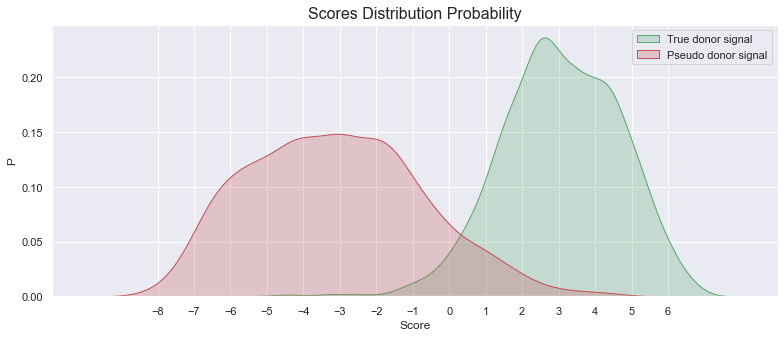

In [17]:
# 真假位点的分值分布图
sns.set(style='darkgrid')
fig,axes = plt.subplots(1,1,figsize=(13,5))
ax1 = sns.kdeplot(scores,shade=True,color="g",bw_adjust=1,cut=3,cumulative=False,label="True donor signal",ax=axes)
ax1 = sns.kdeplot(pseudo_scores,shade=True,color="r",bw_adjust=1,cut=3,cumulative=False,label="Pseudo donor signal",ax=axes)
ax1.set_ylabel('P')
ax1.set_xlabel("Score")
ax1.set_xticks(np.arange(-8,7,1))
ax1.legend()
ax1.set_title('Scores Distribution Probability',fontsize=16)
fig.savefig(f'WAMoutput/Distribution_Probability.png',dpi = 200) #路径+文件名

## 二次WAM

In [18]:
train_all_array = np.array(train_features_df.iloc[:,:-1])
train_all_array = tqdm(train_all_array, desc='Calculating Non scores:')
train_all_scores=list(map(cal_WAM,train_all_array ))

Calculating Non scores:: 100%|██████████████████████████████████████████████████| 4460/4460 [00:00<00:00, 10299.36it/s]


In [19]:
train_all_scores

[2.5780530050479973,
 2.9588041609934423,
 2.6272875741207207,
 2.898034036995245,
 4.217109748566787,
 1.750248380013665,
 3.254391492248846,
 0.21362063352380734,
 2.46447342717774,
 5.742798090816809,
 2.979946137310339,
 4.140943357194106,
 3.440568694317977,
 1.1830718605167077,
 1.7323967292987907,
 1.3040499695552121,
 3.0963160483485863,
 2.655117399998864,
 2.591969610096289,
 3.3209524163020383,
 1.817967504899845,
 5.986375279732903,
 2.6211666769198034,
 3.9933321550571526,
 4.491136617966851,
 2.4539676979267204,
 6.2151659735453855,
 1.7018290236675346,
 2.5597314842952024,
 2.3799307650736425,
 0.6318965032779775,
 2.1070459789446447,
 2.4550723508083427,
 4.025932432056738,
 3.662529417718093,
 4.583069750512283,
 2.3138470062030088,
 0.38127703353230213,
 4.206950844169928,
 3.3675260035640404,
 5.6475315698397885,
 0.6462811239970458,
 2.57497626626618,
 4.123616964261875,
 1.6046297854593847,
 1.3433636501514519,
 -2.5810160332509424,
 1.9429925092471372,
 4.09841609

In [20]:
# train_second = train_features_df.copy()

In [21]:
tqdm.pandas(desc='pandas bar')
train_features_df['WAMScore'] = train_all_scores
Threshold  =-3
# Threshold  =                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
train_features_df['WAMfilter'] = train_features_df.progress_apply(lambda x: 1 if x.WAMScore > Threshold else 0, axis=1)
# 当阈值为-3的时候，训练集少了一半
print(train_features_df.WAMfilter.sum())

pandas bar: 100%|███████████████████████████████████████████████████████████████| 4460/4460 [00:00<00:00, 49143.05it/s]

3351


In [22]:
train_second_df = train_features_df[train_features_df["WAMfilter"]==1].reset_index(drop=True)
train_second_df

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label,WAMScore,WAMfilter
0,0,2,3,2,3,0,0,2,3,0,3,1,1,2.578053,1
1,3,3,1,2,3,0,0,2,3,0,1,1,1,2.958804,1
2,0,2,2,2,3,0,0,2,0,2,0,2,1,2.627288,1
3,1,0,2,2,3,2,2,2,2,2,1,1,1,2.898034,1
4,2,0,2,2,3,2,0,2,3,3,3,0,1,4.217110,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,1,0,2,2,3,3,0,1,0,0,3,0,0,-1.850702,1
3347,3,0,2,2,3,0,1,3,3,1,0,0,0,-0.904728,1
3348,0,2,2,2,3,2,2,2,2,0,0,1,0,-0.201867,1
3349,2,0,2,2,3,0,2,3,1,1,1,0,0,-0.440175,1


In [23]:
train_second_features = train_second_df.iloc[:,:-2]
train_second_features

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label
0,0,2,3,2,3,0,0,2,3,0,3,1,1
1,3,3,1,2,3,0,0,2,3,0,1,1,1
2,0,2,2,2,3,0,0,2,0,2,0,2,1
3,1,0,2,2,3,2,2,2,2,2,1,1,1
4,2,0,2,2,3,2,0,2,3,3,3,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3346,1,0,2,2,3,3,0,1,0,0,3,0,0
3347,3,0,2,2,3,0,1,3,3,1,0,0,0
3348,0,2,2,2,3,2,2,2,2,0,0,1,0
3349,2,0,2,2,3,0,2,3,1,1,1,0,0


In [24]:
# train_filtered[train_filtered["Label"]==0].sample(2080).reset_index(drop=True)
# train_df = pd.concat([train_second_df[train_second_df["Label"]==1],train_filtered[train_filtered["Label"]==0].sample(2080).reset_index(dr

In [25]:
test_all_array = np.array(test_features_df)
test_all_array  = tqdm(test_all_array , desc='Calculating Non scores:')
test_all_scores=list(map(cal_WAM,test_all_array  ))

Calculating Non scores:: 100%|██████████████████████████████████████████████| 151205/151205 [00:14<00:00, 10287.30it/s]


In [26]:
test_fl_df['WAMScore'] = test_all_scores
# Threshold  =-3
# Threshold  =0.43
test_fl_df['WAMfilter'] = test_fl_df.progress_apply(lambda x: 1 if x.WAMScore > Threshold else 0, axis=1)
# 当阈值为-3的时候，训练集少了一半
print(test_fl_df.WAMfilter.sum())

pandas bar: 100%|███████████████████████████████████████████████████████████| 151205/151205 [00:02<00:00, 64995.30it/s]

74307


In [27]:
test_second_df = test_fl_df[test_fl_df["WAMfilter"]==1].reset_index(drop=True)
test_second_df

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label,WAMScore,WAMfilter
0,2,2,2,2,3,2,0,2,1,1,1,0,1,2.124117,1
1,2,3,2,2,3,0,0,2,0,2,0,1,1,2.284183,1
2,3,0,2,2,3,2,0,2,3,2,3,2,1,3.914804,1
3,2,1,2,2,3,0,2,2,3,0,1,3,1,4.173500,1
4,1,0,2,2,3,0,0,3,3,3,3,1,1,1.507802,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74302,0,0,0,2,3,0,2,1,0,2,3,0,0,-2.520864,1
74303,2,1,0,2,3,0,0,0,1,3,1,3,0,-1.652514,1
74304,2,0,3,2,3,3,2,2,0,0,3,3,0,-2.874401,1
74305,3,1,3,2,3,0,0,3,3,0,3,3,0,-1.885621,1


In [28]:
test_second_array =np.array(test_second_df.iloc[:,:-3])
test_second_array 

array([[2, 2, 2, ..., 1, 1, 0],
       [2, 3, 2, ..., 2, 0, 1],
       [3, 0, 2, ..., 2, 3, 2],
       ...,
       [2, 0, 3, ..., 0, 3, 3],
       [3, 1, 3, ..., 0, 3, 3],
       [3, 1, 3, ..., 3, 0, 0]], dtype=int64)

In [29]:
test_filtered_df =test_fl_df[test_fl_df['WAMfilter']==1].iloc[:,0:signal_num]

In [30]:
# 用于贝叶斯网络的测试集
test_second_array_drop =test_second_df.iloc[:,:-3].drop(['0','1'],axis=1)
test_second_array_drop 

,-3,-2,-1,2,3,4,5,6,7,8
0,2,2,2,2,0,2,1,1,1,0
1,2,3,2,0,0,2,0,2,0,1
2,3,0,2,2,0,2,3,2,3,2
3,2,1,2,0,2,2,3,0,1,3
4,1,0,2,0,0,3,3,3,3,1
...,...,...,...,...,...,...,...,...,...,...
74302,0,0,0,0,2,1,0,2,3,0
74303,2,1,0,0,0,0,1,3,1,3
74304,2,0,3,3,2,2,0,0,3,3
74305,3,1,3,0,0,3,3,0,3,3


## 贝叶斯网络

In [31]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
hc = HillClimbSearch(train_second_features, scoring_method=BDeuScore(train_second_features ))
best_model = hc.estimate()
print(best_model.edges())

  0%|                                                                          | 23/1000000 [00:02<29:31:28,  9.41it/s]

[('-2', '-3'), ('-1', '-2'), ('-1', '3'), ('2', 'Label'), ('2', '3'), ('2', '4'), ('2', '8'), ('4', 'Label'), ('4', '3'), ('4', '5'), ('4', '-2'), ('5', '-1'), ('6', '5'), ('7', '6'), ('8', '7'), ('Label', '3'), ('Label', '-2'), ('Label', '-3'), ('Label', '-1'), ('Label', '5'), ('Label', '8')]


In [32]:
edges=[('-2', '-3'), ('-1', '-2'), ('2', '3'), ('4', 'Label'), ('4', '5'), ('4', '3'), ('4', '2'), ('4', '-2'), ('5', '-1'), ('5', 'Label'), ('6', '5'), ('6', '4'), ('7', '6'), ('8', '7'), ('Label', '-1'), ('Label', '2'), ('Label', '3'), ('Label', '-2'), ('Label', '-3')]

In [40]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

# model = BayesianModel(best_model.edges())
model=BayesianModel(edges)
model.fit(train_second_features, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
# model.fit(train_second_features, estimator=MaximumLikelihoodEstimator)
# predict_data=train_df.drop(['0','1','Label'],axis=1)
# y_pred =model.predict(predict_data)
# (y_pred['Label']==train_df['Label'].reset_index(drop=True)).sum()/len(test)#测试集精度

In [43]:
help(BayesianModel.predict_probability)

Help on function predict_probability in module pgmpy.models.BayesianModel:

predict_probability(self, data)
    Predicts probabilities of all states of the missing variables.
    
    Parameters
    ----------
    data : pandas DataFrame object
        A DataFrame object with column names same as the variables in the model.
    
    Examples
    --------
    >>> import numpy as np
    >>> import pandas as pd
    >>> from pgmpy.models import BayesianModel
    >>> values = pd.DataFrame(np.random.randint(low=0, high=2, size=(100, 5)),
    ...                       columns=['A', 'B', 'C', 'D', 'E'])
    >>> train_data = values[:80]
    >>> predict_data = values[80:]
    >>> model = BayesianModel([('A', 'B'), ('C', 'B'), ('C', 'D'), ('B', 'E')])
    >>> model.fit(values)
    >>> predict_data = predict_data.copy()
    >>> predict_data.drop('B', axis=1, inplace=True)
    >>> y_prob = model.predict_probability(predict_data)
    >>> y_prob
        B_0         B_1
    80  0.439178    0.560822
  

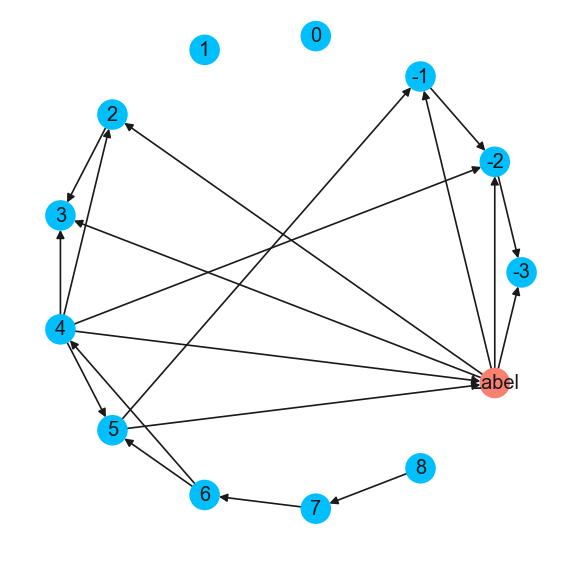

In [35]:
import pygraphviz
import networkx as nx
model_temp=model.copy()
model_temp.add_nodes_from([ node for node in train_second_features.columns 
                                          if not model_temp.has_node([node]) ])
fig, ax1 = plt.subplots(1, 1, figsize=(6,6), dpi=120)
G1 = model_temp
def func(info):
    if info[0] == "Label":
        return 99
    else:
#         print(info)
        return int(info[0])

H = nx.DiGraph()
H.add_nodes_from(sorted(G1.nodes(data=True), key=func))
H.add_edges_from(G1.edges(data=True))

bicolors = ['deepskyblue','salmon']
nodesize = np.array([float(H.degree(v) + 1) for v in H])
nodecolor = np.array([bicolors[int('Label' == i)] for i in H])
nx.draw(H, with_labels=True, node_color=nodecolor,pos = nx.kamada_kawai_layout(H),
         ax=ax1)
fig.savefig(f'{output_name}/network.png',dpi=120)

In [41]:
s =model.predict(test_second_array_drop [-2000:])

100%|██████████████████████████████████████████████████████████████████████████████| 1905/1905 [00:41<00:00, 46.11it/s]


In [42]:
s.sum()

Label    439
dtype: int64

In [106]:
# default_predict =model.predict(test_second_array_drop)
# default_predict.to_csv(f"{output_name}/default_predict.csv",index=None)
# default_predict

In [107]:
from sklearn.metrics import confusion_matrix
def save_to_file(file_name, contents,mode='a+'):
    fh = open(file_name, mode)
    fh.write(contents)
    fh.close()
def draw_confusion_matrix(labels,predicts,name,size=(6, 6),mode='a+',threshold="Default"):
    mat = confusion_matrix(labels,predicts)
    TP = mat[1][1]
    FP = mat[0][1]
    TN = mat[0][0]
    FN = mat[1][0]
    recall  = TP/(FN+TP)
    precision = TP/(FP+TP)
    acc = (TP+TN)/np.sum(mat)
    fpr =  FP/(TN+ FP)
    f1_score = 2*precision*recall/(precision+recall)
    print(f"Precision :{precision}, Recall:{recall},f1_score:{f1_score},Acc:{acc},FPR:{fpr},Sp:{1-fpr}")
    save_to_file(f'{output_name}/WAM_predict.txt', f"\nPrecision :{precision}, Recall:{recall},f1_score:{f1_score},Acc:{acc} \n",mode)

    f, ax = plt.subplots(figsize=size)
    sns.set()
    sns.heatmap(mat, square=True, annot=True, fmt='d',cmap='Blues' ,cbar=False,
                xticklabels=['pseudo donor','real donor'],
                yticklabels=['pseudo donor','real donor'],)
    ax.set_xlabel(f'Predicted label\nPrecision :{precision:.2f}, Recall:{recall:.2f},F1_score:{f1_score:.2f}')
    ax.set_ylabel(f'True label');
    plt.title(f"Confusion Matrix(Threshold:{threshold})\n",fontsize=15)
    f.savefig(f"{output_name}/{name}.png",dpi=120)


In [108]:

y_pred =model.predict_probability(test_second_array_drop)



FileNotFoundError: [Errno 2] No such file or directory: 'BN2Double/BN2_predict_scores.csv'

In [139]:
np.log(y_pred['Label_1']/y_pred['Label_0'])

0        2.014012
1        2.051606
2        3.787428
3        3.823634
4        2.078688
           ...   
74302   -2.016772
74303   -4.205180
74304   -4.795193
74305   -2.461692
74306   -2.461692
Length: 74307, dtype: float64

In [141]:
BNDouble_predict_scores

0        2.014012
1        2.051606
2        3.787428
3        3.823634
4        2.078688
           ...   
74302   -2.016772
74303   -4.205180
74304   -4.795193
74305   -2.461692
74306   -2.461692
Length: 74307, dtype: float64

In [137]:
test_fl_df.loc[test_fl_df["WAMfilter"]==1]

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label,WAMScore,WAMfilter,D-Score
0,2,2,2,2,3,2,0,2,1,1,1,0,1,2.124117,1,2.014012
1,2,3,2,2,3,0,0,2,0,2,0,1,1,2.284183,1,2.051606
2,3,0,2,2,3,2,0,2,3,2,3,2,1,3.914804,1,3.787428
3,2,1,2,2,3,0,2,2,3,0,1,3,1,4.173500,1,3.823634
4,1,0,2,2,3,0,0,3,3,3,3,1,1,1.507802,1,2.078688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151187,0,0,0,2,3,0,2,1,0,2,3,0,0,-2.520864,1,NaN
151188,2,1,0,2,3,0,0,0,1,3,1,3,0,-1.652514,1,NaN
151191,2,0,3,2,3,3,2,2,0,0,3,3,0,-2.874401,1,NaN
151192,3,1,3,2,3,0,0,3,3,0,3,3,0,-1.885621,1,NaN


In [179]:
predict_scores = np.log(y_pred['Label_1']/y_pred['Label_0'])
# predict_scores = y_pred['Label_1']
test_fl_df.loc[test_fl_df["WAMfilter"]==0,"D-Score"]= -99
test_fl_df.loc[test_fl_df["WAMfilter"]==1,"D-Score"]= predict_scores
test_fl_df = test_fl_df.fillna(-99)

In [180]:
test_fl_df[test_fl_df.isna().any(axis=1)]

,-3,-2,-1,0,1,2,3,4,5,6,7,8,Label,WAMScore,WAMfilter,D-Score


In [182]:
test_fl_df.to_csv("BN2Double/1Test_info.csv",index=None)

In [183]:

BNDouble_test_labels= test_fl_df["Label"]

BNDouble_predict_scores= test_fl_df["D-Score"]


In [184]:
BNDouble_predict_scores.to_csv("BN2Double/scores_info.csv",index=None)

In [185]:
BN_pred=pd.read_csv(f"BN2output/WAM&BN_predict_scores.csv")
BN_predict_scores = np.log(BN_pred['Label_1']/BN_pred['Label_0'])
BN_test_labels= pd.read_csv(f"BN2output/Test_predict.csv")["label"]

In [186]:
WAM_predict_scores=pd.read_csv("WAMoutput/WAM_predict_scores.csv")
WAM_test_labels = pd.read_csv("WAMoutput/Test_predict.csv")['label']

In [187]:
SVM_RBF_labels = [1]*2079+[0]*149255
SVM_RBF_scores = pd.read_csv("SVMoutput/SVM_predict_probs.csv")['RBF']

In [188]:
SVM_test_labels = [1]*2079+[0]*148357

In [189]:
# SVM_test_labels =pd.read_csv("SVMoutput/Test_predict.csv")['label']
# SVM_RBF_scores = pd.read_csv("SVMoutput/SVM_predict_scores.csv")['RBF']
SVM_linear_scores = pd.read_csv("SVMoutput/SVM_predict_scores.csv")['linear']
SVM_poly_scores = pd.read_csv("SVMoutput/SVM_predict_scores.csv")['poly']

In [190]:
test_labels = [WAM_test_labels,BN_test_labels,BNDouble_test_labels,SVM_test_labels,SVM_test_labels]
test_scores = [WAM_predict_scores,BN_predict_scores,BNDouble_predict_scores,SVM_linear_scores,SVM_poly_scores]

In [191]:
BNDouble_test_labels

0         1
1         1
2         1
3         1
4         1
         ..
151200    0
151201    0
151202    0
151203    0
151204    0
Name: Label, Length: 151205, dtype: int64

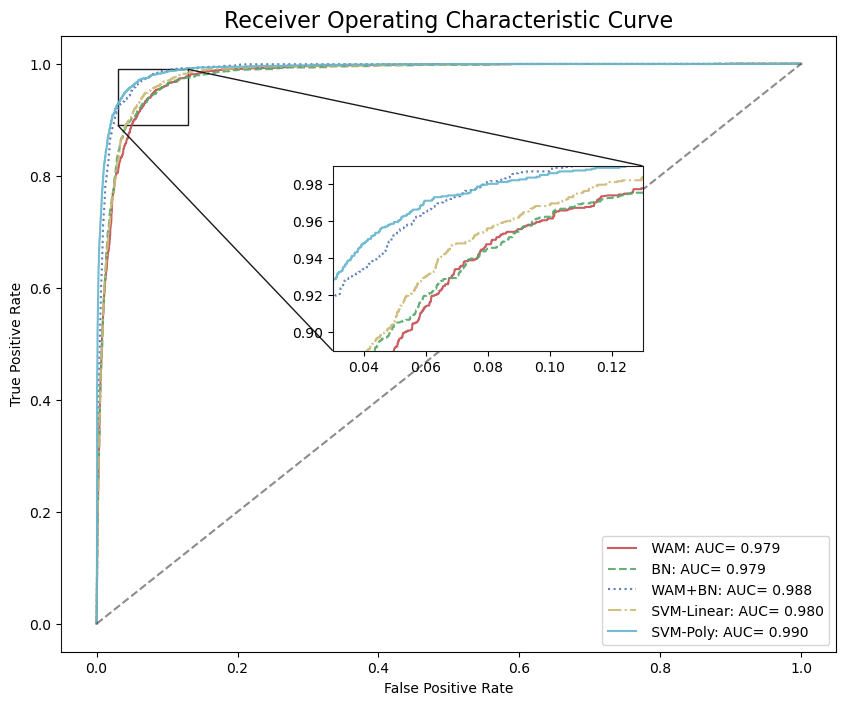

In [210]:
# ROC plot
# problem ： 如何画不同核的图在一个图里
from sklearn.metrics import roc_curve, auc  ###计算roc和auc
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
import matplotlib.pyplot as plt
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

# def ROC_plot(label, y_prob):
#     fpr, tpr, thresholds = roc_curve(label, y_prob)
#     roc_auc = auc(fpr, tpr)
#     optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, label=f"BN:AUC={roc_auc:.3f}",color='#ad2102',alpha=0.8)
#     plt.plot([0, 1], [0, 1],"k--",alpha=0.5)
#     plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
#     plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
#     plt.title("Receiver Operating Characteristic Curve")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     plt.legend(loc="lower right")
#     f = plt.gcf()  #获取当前图像
#     f.savefig(f'{output_name}/ROC_plot.png',dpi=120)
#     plt.show()
#     return optimal_th
def plot_roc(labels, predict_probs, titles):
    color = ['r', 'g', 'b', 'y','c','m']                                                                 
    linestyles = ['-','--',':','-.']
#     markers = ['v','o','p','+','1','D',',','.']
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    for idx, predict_prob in enumerate(predict_probs):
        fpr, tpr,thresholds=roc_curve(labels[idx], predict_prob)
        roc_auc=auc(fpr, tpr)
        if idx==2:
            optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
        c = color[idx%len(color)]                                                                     
        l =linestyles[idx%len(linestyles)]
#         m = markers [idx%len( markers )]
        ax.plot(fpr, tpr,'b',label=f' {titles[idx]}: AUC= {roc_auc:.3f}', color=c, linestyle=l, alpha=0.9,markevery=20)  
        ax.legend(loc='lower right')
    # 
    axins = inset_axes(ax, width="40%", height="30%",loc='upper center',
                   bbox_to_anchor=(0.05, -0.2, 1, 1),
                   bbox_transform=ax.transAxes)
    for idx, predict_prob in enumerate(predict_probs):
        false_positive_rate,true_positive_rate,thresholds=roc_curve(labels[idx], predict_prob)
        roc_auc=auc(false_positive_rate, true_positive_rate)
        c = color[idx%len(color)]                                                                     
        l =linestyles[idx%len(linestyles)]
        
#         m = markers [idx%len( markers )]
        axins.plot(false_positive_rate, true_positive_rate,'b', color=c, linestyle=l, alpha=0.9,markevery=20)  

    axins.set_xlim(0.03, 0.13)
    axins.set_ylim(0.89, 0.99)
    #
    mark_inset(ax, axins, loc1=3,loc2=1, fc="none", ec='k', lw=1)
    ax.plot([0,1],[0,1],'k--',alpha=0.5)
    ax.set_title("Receiver Operating Characteristic Curve",fontsize=16)
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")

    ax.spines['left'].set_color('k')
    [axins.spines[loc_axis].set_color('k') for loc_axis in ['top','right','bottom','left']]
    plt.savefig(f'{output_name}/ROC_plot.png',dpi=120)
    plt.show()
    return optimal_th

plt.style.use('default')

optimal_th=plot_roc(test_labels,test_scores,titles=["WAM","BN","WAM+BN","SVM-Linear","SVM-Poly"])



In [211]:
print(optimal_th)

-0.06764144320828155


Precision :0.18692286167335137, Recall:0.963924963924964,f1_score:0.31312500000000004,Acc:0.9418537746767633,FPR:0.05845392486890281,Sp:0.9415460751310972


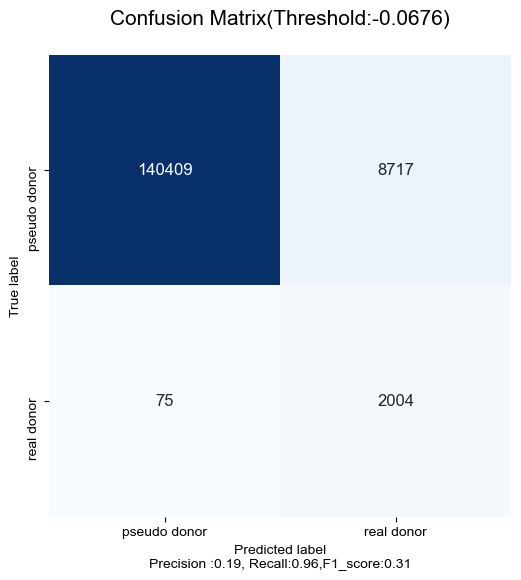

In [212]:
predict_label =[1 if i >optimal_th else 0 for i in BNDouble_predict_scores ]
draw_confusion_matrix(BN_test_labels, predict_label,name=f"confusion_matrix_ROC_best",threshold=f'{optimal_th:.4f}')

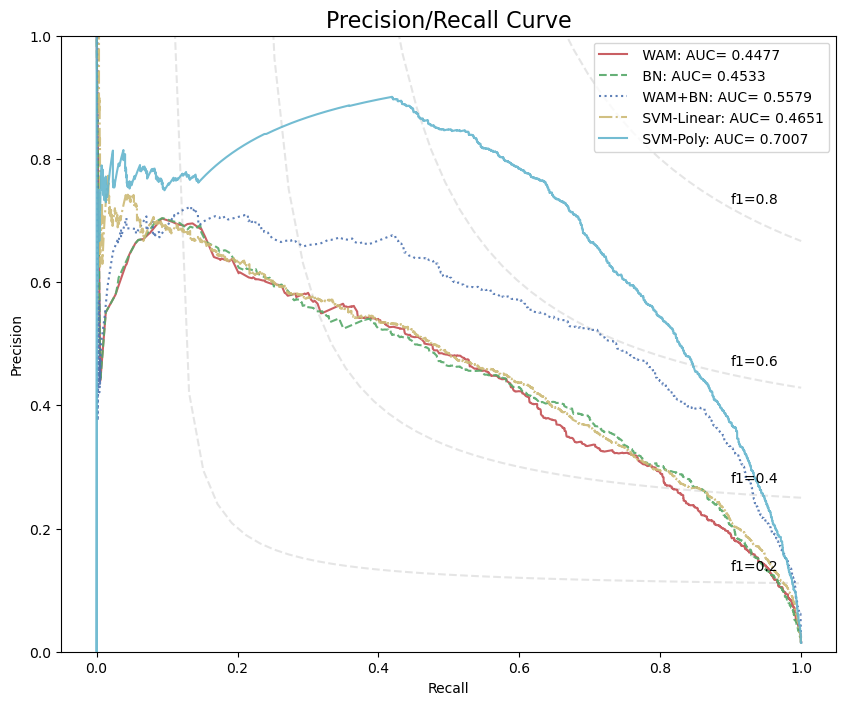

In [200]:
from sklearn.metrics import precision_recall_curve


# def plot_pr(labels, predict_probs):
#     plt.figure(figsize=(8, 6))
#     precision, recall, thresholds = precision_recall_curve(labels, predict_probs)
#     pr_auc=auc(recall, precision)
#     print(precision)
#     f_scores = np.linspace(0.2, 0.8, num=4)
#     for f_score in f_scores:
#         x = np.linspace(0.01, 1)
#         y = f_score * x / (2 * x - f_score)
#         l, = plt.plot(x[y >= 0], y[y >= 0], color='gray',linestyle='--' ,alpha=0.2)
#         plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
        
#     plt.plot(recall,precision,'b',label=f'BN:AUC={pr_auc:.4f}', alpha=0.8,color="#135200")  
#     plt.legend(loc='lower right')
#     plt.plot([0,1],[1,0],'k--',alpha=0.5)
#     plt.title('Precision/Recall Curve',fontsize=16)# give plot a title
#     plt.xlabel('Recall')# make axis labels
#     plt.ylabel('Precision')
#     plt.ylim(0,1.05)
#     plt.legend(loc="upper right")
#     f = plt.gcf()  #获取当前图像
#     f.savefig(f'{output_name}/Plot_PR.png',dpi=120)
#     plt.show()
#     return thresholds
def plot_pr(labels, predict_probs, titles):
    color = ['r', 'g', 'b', 'y','c','m']                                                                 
    linestyles = ['-','--',':','-.']
    plt.figure(figsize=(10, 8))
    f_scores = np.linspace(0.2, 0.8, num=4)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray',linestyle='--' ,alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    for idx, predict_prob in enumerate(predict_probs):
        precision, recall, thresholds = precision_recall_curve(labels[idx], predict_prob)
        pr_auc=auc(recall, precision)
        c = color[idx%len(color)]                                                                     

        l =linestyles[idx%len(linestyles)]
        plt.plot(recall,precision,'b',label=f' {titles[idx]}: AUC= {pr_auc:.4f}',color=c, linestyle=l, alpha=0.9,markevery=20)  
        plt.legend(loc='lower right')
    plt.ylim(0,1)
    # plt.plot([0,1],[1,0],color='gray',linestyle='--',alpha=0.5)
    plt.title('Precision/Recall Curve',fontsize=16)# give plot a title
    plt.xlabel('Recall')# make axis labels
    plt.ylabel('Precision')
    plt.legend(loc="upper right")
    f = plt.gcf()  
    f.savefig(f'{output_name}/PR_plot.png',dpi=120)
    plt.show()
plt.style.use('default')
thresholds=plot_pr(test_labels,test_scores,titles=["WAM","BN","WAM+BN","SVM-Linear","SVM-Poly"])

# y_true = np.array([1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0])
# y_scores = np.array([0.9, 0.75, 0.86, 0.47, 0.55, 0.56, 0.74, 0.62, 0.5, 0.86, 0.8, 0.47, 0.44, 0.67, 0.43, 0.4, 0.52, 0.4, 0.35, 0.1])
# plot_pr(y_true ,y_scores)

In [204]:
thresholds =np.arange(-10,10,0.1)
def cal_thresholds_info(test_labels,pred,thresholds):
    TPs  = []
    FPs = []
    TNs = []
    FNs = []
    thresholds = tqdm(thresholds, desc=f'LOADING')
    for threshold in thresholds:
        predict_label =[1 if i >= threshold else 0 for i in pred ]
        mat = confusion_matrix(test_labels,predict_label)
        TP = mat[1][1]
        FP = mat[0][1]
        TN = mat[0][0]
        FN = mat[1][0]

        TPs.append(TP)
        FPs.append(FP)
        TNs.append(TN)
        FNs.append(FN)
    predict_df = pd.DataFrame({"Threshold":thresholds,"TP":TPs,"FP":FPs,"TN":TNs,"FN":FNs})
    predict_df["Recall"] = predict_df["TP"] /(predict_df["TP"]+predict_df["FN"])
    predict_df["Precision"] = predict_df["TP"] /(predict_df["TP"]+predict_df["FP"])
    predict_df["F1-Score"] = 2*predict_df["Recall"]*predict_df["Precision"] /(predict_df["Recall"]+predict_df["Precision"])
    predict_df["Sn"] = predict_df["TN"] /(predict_df["TN"]+predict_df["FP"])
    predict_df["FPR"] =  1- predict_df["Sn"]
    predict_df["Acc"] =  (predict_df["TP"] + predict_df["TN"]) / (predict_df["TP"] + predict_df["TN"]+predict_df["FP"] + predict_df["FN"])
    return predict_df
BNpredict_df=cal_thresholds_info(BNDouble_test_labels,BNDouble_predict_scores,thresholds)
BNpredict_df.to_csv(f"{output_name}/Predict_info.csv",index=None)

LOADING: 100%|███████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.39it/s]


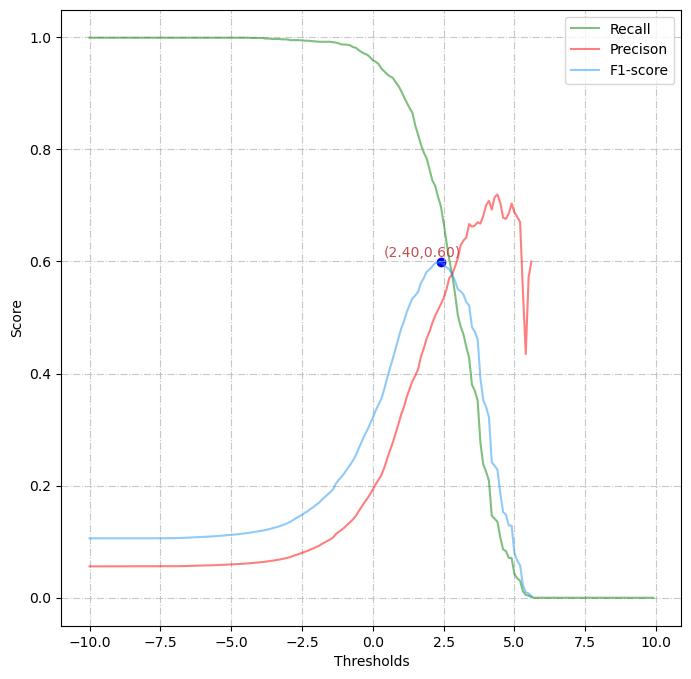

In [205]:
def plot_PRF(predict_df):
    f, ax = plt.subplots(figsize=(8,8))
    alpha=0.5
    ymax = predict_df["F1-Score"].max()
    xmax = thresholds[predict_df["F1-Score"].idxmax()]
#     print(xmax)
    plt.scatter(xmax,ymax,color='blue')
#     plt.plot([xmax,xmax],[0,ymax],color='gray',linestyle='--',lw=1)
#     plt.plot([thresholds[0],xmax],[ymax,ymax],color='gray',linestyle='--',lw=1)
    plt.text(xmax-2,ymax+0.01,f"({xmax:.2f},{ymax:.2f})",color='r')
    plt.plot(thresholds,predict_df["Recall"], color='green', label='Recall',alpha=alpha)
    plt.plot(thresholds, predict_df["Precision"], color='red', label='Precison',alpha=alpha)
    plt.plot(thresholds, predict_df["F1-Score"], color='#2196f3', label='F1-score',alpha=alpha)
    plt.xlabel("Thresholds")
    plt.ylabel("Score")
#     plt.xticks(np.arange(0,1.1,0.1))
#     plt.yticks(np.arange(0,1.1,0.1))
#     plt.xlim([-0.05,0.9])
    plt.legend(loc="upper right") # 图标在外侧
    plt.grid(linestyle='-.',alpha=0.7)
#     plt.axhline(y=0,ls=":",c="yellow")
#     plt.axvline(x=4,ls="-",c="green")
    plt.show()
   
    return f,xmax
plt.style.use("default")
f,th_best=plot_PRF(BNpredict_df)
f.savefig(f"{output_name}/Different Threshold Predictions.png",dpi=120)

In [207]:
th_best

2.399999999999956

Precision :0.5234149855907781, Recall:0.6988936988936989,f1_score:0.5985581874356335,Acc:0.9871102146093053,FPR:0.008871692394351085,Sp:0.991128307605649


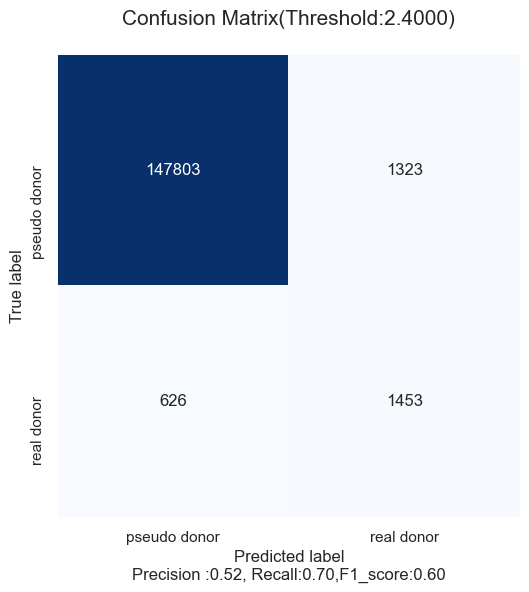

In [208]:

predict_label =[1 if i >th_best else 0 for i in BNDouble_predict_scores]
draw_confusion_matrix(BN_test_labels, predict_label,name=f"confusion_matrix_p_{th_best:.4f}",threshold=f'{th_best:.4f}')